# Week 1: Introduction to Computer Vision

## Notebook 1: Similarity Learning with a Siamese Neural Network using Keras Functional

Welcome to the second week of Applied AI Study Group! We will work through a couple of crucial Computer Vision tasks with the commonly used frameworks and libraries this week.

In the previous week, you tackled the simple classification tasks using Dense Neural Networks and Convolutional Neural Networks. Hence, you are already familiar with essential elements of Computer Vision models we are going to build today.

In this notebook, we are starting our journey of Computer Vision tasks with Siamese Neural Networks to learn Similarity. 

This notebook is prepared using the following three sources: [PyImageSearch 1](https://www.pyimagesearch.com/2020/11/23/building-image-pairs-for-siamese-networks-with-python/), [PyImageSearch 2](https://www.pyimagesearch.com/2020/11/30/siamese-networks-with-keras-tensorflow-and-deep-learning/), and [PyImageSearch 3](https://www.pyimagesearch.com/2020/12/07/comparing-images-for-similarity-using-siamese-networks-keras-and-tensorflow/).

### 1. Similarity Learning

Why do we need learning similarity? Would not be enough if we have a classification model that predicts whether an input belongs a category or not? 

The answer is no. Because it would not scale well to new categories added to the dataset we have. Let's consider case: we train a model for recognizing employees in a company's entrance to allow them to go into the building. For instance, we have 100 different employees and our model can successfully recognize them. What happens someone leave or another people join to the company? We would need a couple of images and train our model again and again for each case every time. The thing is we do not need to know whom we are recognizing, right? We just need to know that that person is in our employee list. So, it is better to train a model that differentiates whether that person is in our company or not. For this case, we would just need to measure similarity between the image we have for that employee and the person in the entrance to decide.

Now, we know why we need similarity learning. The next question is how we can design a model and training schemas to perform our task successfully. Since we do not need which category or which humanbeing we are recognizing, we do not need to have labels of all objects we have. We just need to differentiate whether two things are same or not. Hence, we can intuitively think this would be a binary classification task in which the output of our model will be whether the same or not, hence 0 or 1. We know what our output will be, then, the question will be what we are going to learn? 

We will learn a similarity function that returns a low similarity score for two instances belong to the different classes, high otherwise. Then, we can set a threshold to decide whether they belong to the same or not. Finally, having almost everything in our task decided, we just need to figure out what our model will be like to successfully reach a high-accuracy model. We will design a siamese neural network in which we will talk about in the next section.

### 2. Siamese Neural Networks

Siamese Neural Networks are specialized for comparing two different input vectors. The reason we call this type of networks as Siamese (also called twin) is we use the same set of (shared weights) layers to process given inputs. After the processing of input vectors, we compare the extracted representations to decide whether inputs are similar or not. To do that, we can define distance functions such as euclidean.

![Siamese Neural Network Model Architecture](./images/siamese_nn.png "Example Siamese Neural Network")

### 3. Installation

As in the previous Starter Week 0, we will use Python together with Jupyter to go through all our notebooks. If you had not installed the required packages to run these notebooks today, please go to the [Week 0 - Notebook 1](https://github.com/inzva/Applied-AI-Study-Group/blob/add-frameworks-week/Applied%20AI%20Study%20Group%20%236%20-%20January%202022/Week%200/1-mnist_classification_dense_tensorflow2.ipynb) and follow the instructions for all requirements.

### 4. Imports and Checks

Also, for installing necessary packages, please use the following instructions:

For tensorflow, you can follow the previous week's instructions: [Week 0 - Notebook 1](https://github.com/inzva/Applied-AI-Study-Group/blob/add-frameworks-week/Applied%20AI%20Study%20Group%20%236%20-%20January%202022/Week%200/1-mnist_classification_dense_tensorflow2.ipynb)

Keras is already installed with Tensorflow 2.

Below we import the necessary libraries for data exploration and some further data operations. If any of these packages are not installed on your system, please install them via `pip` or `conda`:

For cv2 case, please use the following: 

    pip install opencv-python

In [1]:
from tensorflow.keras.datasets import mnist
import tensorflow as tf
from imutils import build_montages
import numpy as np
import cv2
import matplotlib.pyplot as plt

Below we will use `Keras Datasets` to load `MNIST` dataset. We can also directly separate data into train and test sets with training data and ground-truth data. For API reference: [Keras Datasets](https://keras.io/api/datasets/).

In [2]:
(trainX, trainY), (testX, testY) = mnist.load_data()
print("range of inputs: ", np.min(trainX), np.max(trainX))
print("range of outputs: ", np.min(trainY), np.max(trainY))

range of inputs:  0 255
range of outputs:  0 9


We need to have input pairs for training our model. Because we will learn to measure similarity, not classify the input data. Hence, we need to process our dataset to have pairs with their corresponding labels. For the input images belonging to same classes we will have label 1, and 0 otherwise. The following function aims to create pairs from given dataset.

In [3]:
def make_pairs(images, labels):
    pairImages=[]
    pairLabels=[]
    numClasses = len(np.unique(labels))
    idx = [np.where(labels == i)[0] for i in range(0, numClasses)]
    for i in range(0, numClasses):
        idxs = np.where(labels == i)[0]
        #print("{}: {} {}".format(i, len(idxs), idxs))
    for idxA in range(len(images)):
        currentImage = images[idxA]
        label = labels[idxA]
        idxB = np.random.choice(idx[label])
        posImage = images[idxB]
        pairImages.append([currentImage, posImage])
        pairLabels.append([1])
        negIdx = np.where(labels != label)[0]
        negImage = images[np.random.choice(negIdx)]
        pairImages.append([currentImage, negImage])
        pairLabels.append([0])
    return (np.array(pairImages), np.array(pairLabels))

We call our function to have pairs.

In [4]:
(pairTrain_vis, labelTrain_vis) = make_pairs(trainX, trainY)
(pairTest_vis, labelTest_vis) = make_pairs(testX, testY)

Let's visualize a small set of our dataset to observe what it looks like. In this loop, we randomly sample 49 pairs with their labels. 

In [5]:
images = []
for i in np.random.choice(np.arange(0, len(pairTrain_vis)), size=(49,)):
    # grab the current image pair and label
    imageA = pairTrain_vis[i][0]
    imageB = pairTrain_vis[i][1]
    label = labelTrain_vis[i]
    
    output = np.zeros((36, 60), dtype="uint8")
    pair = np.hstack([imageA, imageB])
    output[4:32, 0:56] = pair
    
    text = "neg" if label[0] == 0 else "pos"
    color = (0, 0, 255) if label[0] == 0 else (0, 255, 0)
    
    vis = cv2.merge([output] * 3)
    vis = cv2.resize(vis, (96, 51), interpolation=cv2.INTER_LINEAR)
    cv2.putText(vis, text, (2, 12), cv2.FONT_HERSHEY_SIMPLEX, 0.75,
        color, 2)

    images.append(vis)

Using CV2 functions for visualizing and build_montages from imutils, we can visualize our 49 pairs in 7x7 grid where each grid is a pair.

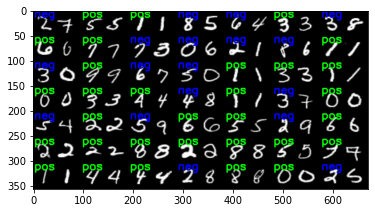

In [6]:
montage = build_montages(images, (96, 51), (7, 7))[0]
plt.imshow(montage)

Necessary for specifying some training parameters and model - plot paths.

In [7]:
import os
IMG_SHAPE = (28, 28, 1)
BATCH_SIZE = 64
EPOCHS = 10

BASE_OUTPUT = "output"
MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "siamese_model"])
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])

Below we import necessary layers we will use for building our model.

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D

Here we will our network using Keras Functional API. For further information, [Keras Functional API](https://keras.io/guides/functional_api/)

Keras Functional treats building Deep Learning models as Directed Acyclic Graphs (DAG) of layers. While building our model, we also specify what the input is for correspoding layer as well. You can study the following code to understand better.

In [9]:
def build_siamese_model(inputShape, embeddingDim=48):
    inputs = Input(inputShape)
    x = Conv2D(64, (2, 2), padding="same", activation="relu")(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)
    
    x = Conv2D(64, (2, 2), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    pooledOutput = GlobalAveragePooling2D()(x)
    outputs = Dense(embeddingDim)(pooledOutput)

    model = Model(inputs, outputs)
    return model

We have built our model. As we have already stated, we need a similarity measure between the output vectors of our model. Hence, we will define our similarity metric, aka distance function, as in following code.

In [10]:
def euclidean_distance(vectors):

    (featsA, featsB) = vectors

    sumSquared = K.sum(K.square(featsA - featsB), axis=1,
        keepdims=True)

    return K.sqrt(K.maximum(sumSquared, K.epsilon())) # If the distance is greater than 1e-7, use it, otherwise replace it with 1e-7. WHY???

In [11]:
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
from tensorflow.keras.datasets import mnist

In the following cell, we scale our image pixel values to [0, 1] and handle the tensor shape issue. Then, we obtain our training-ready training and test pair sets.

In [12]:
trainX_n = trainX / 255.0
testX_n = testX / 255.0

trainX_e = np.expand_dims(trainX_n, axis=-1)
testX_e = np.expand_dims(testX_n, axis=-1)

(pairTrain, labelTrain) = make_pairs(trainX_e, trainY)
(pairTest, labelTest) = make_pairs(testX_e, testY)

The following cell is where we built the order of processing of given input images. As in model building, Keras Functional requires us to specify the execution order of functions. Hence, we will build our model as follows:

In [13]:
imgA = Input(shape=IMG_SHAPE)
imgB = Input(shape=IMG_SHAPE)

featureExtractor = build_siamese_model(IMG_SHAPE)
featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)
distance = Lambda(euclidean_distance)([featsA, featsB]) # Lambda is used for making custom Layer objects out of custom functions
outputs = Dense(1, activation="sigmoid")(distance)
model = Model(inputs=[imgA, imgB], outputs=outputs)

Using keras's summary() function, we can double-check our final model. We can check layer types, output vector shapes, number of trainable parameters, and which layers are connected to which vectors or layers.

In [14]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
functional_1 (Functional)       (None, 48)           19888       input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           functional_1[0][0]    

Using keras functions, we configure our training design choices and later, we train our model using fit() function.

In [15]:
model.compile(loss="binary_crossentropy", optimizer="adam",
    metrics=["accuracy"])

# Override number of epochs
EPOCHS = 10

# train the model
print("training model...")
history = model.fit(
    [pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],
    validation_data=([pairTest[:, 0], pairTest[:, 1]], labelTest[:]),
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS)

training model...
Epoch 1/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.6934 - accuracy: 0.4970 - val_loss: 0.6934 - val_accuracy: 0.4961
Epoch 2/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.6932 - accuracy: 0.4989 - val_loss: 0.6933 - val_accuracy: 0.4977
Epoch 3/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.6932 - accuracy: 0.4982 - val_loss: 0.6932 - val_accuracy: 0.4995
Epoch 4/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.6932 - accuracy: 0.4975 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.6932 - accuracy: 0.5016 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 6/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.6932 - accuracy: 0.5009 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 7/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.6932 - accuracy: 0.4985 - val_los

We can observe our training metrics using history variable of our training call.

In [16]:
def plot_training(H):
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(H.history["loss"], label="train_loss")
    plt.plot(H.history["val_loss"], label="val_loss")
    plt.plot(H.history["accuracy"], label="train_acc")
    plt.plot(H.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")

Let's plot:

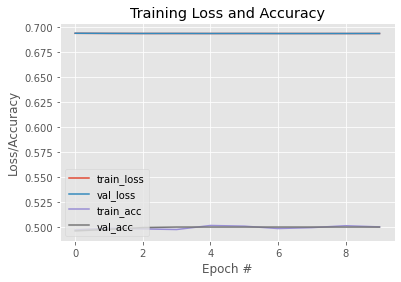

In [17]:
# plot the training history
plot_training(history)

And, we can test our trained model to understand whether it performs well. Also, we will visualize a couple of test pairs to understand where our model may fail.

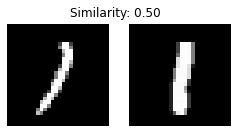

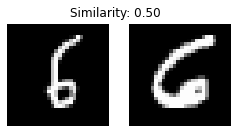

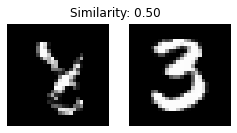

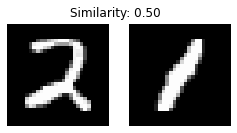

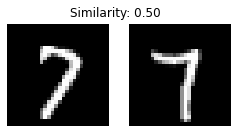

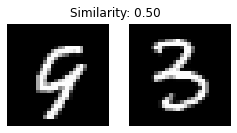

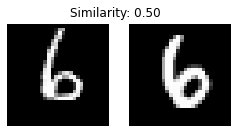

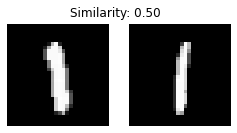

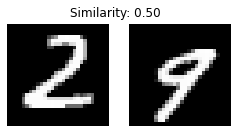

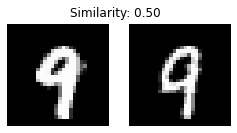

In [19]:
import numpy as np
num_test = len(pairTest)
pairs = np.random.choice(num_test, 10)
for i, idx in enumerate(pairs):
    # load both the images and convert them to grayscale
    imageA = pairTest[idx][0]
    imageB = pairTest[idx][1]
    # create a copy of both the images for visualization purpose
    origA = imageA.copy()
    origB = imageB.copy()
    # add channel a dimension to both the images
    imageA = np.expand_dims(imageA, axis=-1)
    imageB = np.expand_dims(imageB, axis=-1)
    # add a batch dimension to both images
    imageA = np.expand_dims(imageA, axis=0)
    imageB = np.expand_dims(imageB, axis=0)
    # scale the pixel values to the range of [0, 1]
    imageA = imageA / 255.0
    imageB = imageB / 255.0
    # use our siamese model to make predictions on the image pair,
    # indicating whether or not the images belong to the same class
    preds = model.predict([imageA, imageB])
    proba = preds[0][0]
    # initialize the figure
    fig = plt.figure("Pair #{}".format(i + 1), figsize=(4, 2))
    plt.suptitle("Similarity: {:.2f}".format(proba))
    # show first image
    ax = fig.add_subplot(1, 2, 1)
    plt.imshow(origA.reshape((28,28)), cmap=plt.cm.gray)
    plt.axis("off")
    # show the second image
    ax = fig.add_subplot(1, 2, 2)
    plt.imshow(origB.reshape((28,28)), cmap=plt.cm.gray)
    plt.axis("off")
    # show the plot
    plt.show()